In [3]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [4]:
filePath = "gs://dataproc-staging-us-central1-762478826489-su9ldjls/Pokemon.csv"

# Read in file
df = spark.read.format('com.databricks.spark.csv').\
                       options(header='true', \
                       inferschema='true').\
            load(filePath,header=True);

# Rename columns for easy access
df = df.withColumnRenamed("Type 1", "Type_1") \
       .withColumnRenamed("Type 2", "Type_2") \
       .withColumnRenamed("Sp. Atk", "Sp_Atk") \
       .withColumnRenamed("Sp. Def", "Sp_Def")
df.show(5,True)
df.printSchema()

+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
|  #|                Name|Type_1|Type_2|Total| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|Generation|Legendary|
+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
|  1|           Bulbasaur| Grass|Poison|  318| 45|    49|     49|    65|    65|   45|         1|    false|
|  2|             Ivysaur| Grass|Poison|  405| 60|    62|     63|    80|    80|   60|         1|    false|
|  3|            Venusaur| Grass|Poison|  525| 80|    82|     83|   100|   100|   80|         1|    false|
|  3|VenusaurMega Venu...| Grass|Poison|  625| 80|   100|    123|   122|   120|   80|         1|    false|
|  4|          Charmander|  Fire|  NULL|  309| 39|    52|     43|    60|    50|   65|         1|    false|
+---+--------------------+------+------+-----+---+------+-------+------+------+-----+----------+---------+
only showing top 5 rows

root
 |-- #:

In [5]:
# Convert the data to vectors
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=["HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed"], outputCol="features")
dataset = vecAssembler.transform(df)
dataset.select("Type_1", "features").show(10)

+------+--------------------+
|Type_1|            features|
+------+--------------------+
| Grass|[45.0,49.0,49.0,6...|
| Grass|[60.0,62.0,63.0,8...|
| Grass|[80.0,82.0,83.0,1...|
| Grass|[80.0,100.0,123.0...|
|  Fire|[39.0,52.0,43.0,6...|
|  Fire|[58.0,64.0,58.0,8...|
|  Fire|[78.0,84.0,78.0,1...|
|  Fire|[78.0,130.0,111.0...|
|  Fire|[78.0,104.0,78.0,...|
| Water|[44.0,48.0,65.0,5...|
+------+--------------------+
only showing top 10 rows



In [6]:
import numpy as np
cost = np.zeros(20)
for k in range(2,19):
    # Train model
    kmeans = KMeans().setK(19).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(dataset)
    
    # Make prediction
    predictions = model.transform(dataset)
    
    # Evaluate
    evaluator = ClusteringEvaluator(predictionCol="cluster")
    cost[k] = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(cost[k]))
    

Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared euclidean distance = 0.24423548882932786
Silhouette with squared e

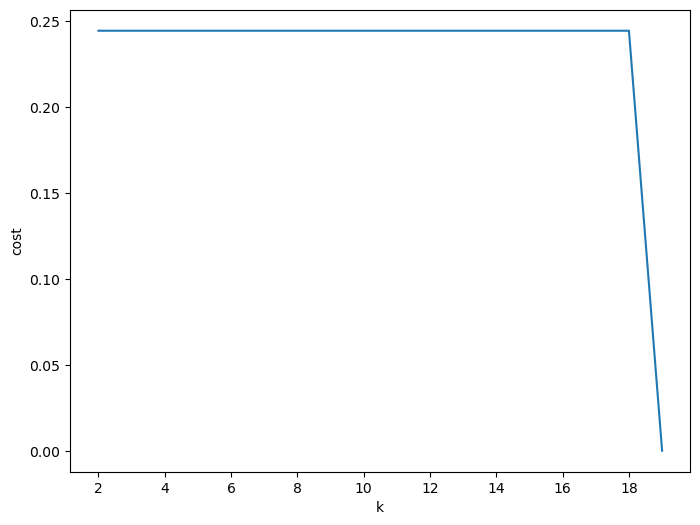

In [7]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()
# Showing plot (what number of clusters are ideal)

In [8]:
# Choose k = 19 (18 clusters)
kmeans = KMeans().setK(19).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")

cluster = model.transform(dataset)
fin_cluster = cluster.select("Type_1", "HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed", "cluster")
fin_cluster.show(10)

+------+---+------+-------+------+------+-----+-------+
|Type_1| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|cluster|
+------+---+------+-------+------+------+-----+-------+
| Grass| 45|    49|     49|    65|    65|   45|      5|
| Grass| 60|    62|     63|    80|    80|   60|      2|
| Grass| 80|    82|     83|   100|   100|   80|     14|
| Grass| 80|   100|    123|   122|   120|   80|     14|
|  Fire| 39|    52|     43|    60|    50|   65|     18|
|  Fire| 58|    64|     58|    80|    65|   80|     15|
|  Fire| 78|    84|     78|   109|    85|  100|     14|
|  Fire| 78|   130|    111|   130|    85|  100|     13|
|  Fire| 78|   104|     78|   159|   115|  100|     14|
| Water| 44|    48|     65|    50|    64|   43|      5|
+------+---+------+-------+------+------+-----+-------+
only showing top 10 rows



In [9]:
# Write to csv
csv_filepath = 'gs://dataproc-staging-us-central1-762478826489-su9ldjls/clusters.csv'
fin_cluster.write.mode("overwrite").format("csv").save(csv_filepath)
spark.read.format('csv').load(csv_filepath).show(10)

+-----+---+---+---+---+---+---+---+
|  _c0|_c1|_c2|_c3|_c4|_c5|_c6|_c7|
+-----+---+---+---+---+---+---+---+
|Grass| 45| 49| 49| 65| 65| 45|  5|
|Grass| 60| 62| 63| 80| 80| 60|  2|
|Grass| 80| 82| 83|100|100| 80| 14|
|Grass| 80|100|123|122|120| 80| 14|
| Fire| 39| 52| 43| 60| 50| 65| 18|
| Fire| 58| 64| 58| 80| 65| 80| 15|
| Fire| 78| 84| 78|109| 85|100| 14|
| Fire| 78|130|111|130| 85|100| 13|
| Fire| 78|104| 78|159|115|100| 14|
|Water| 44| 48| 65| 50| 64| 43|  5|
+-----+---+---+---+---+---+---+---+
only showing top 10 rows



In [10]:
# Making a cluster of k=20 (19 clusters) despite evaluation to see if match by typings
kmeans = KMeans().setK(20).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")

cluster = model.transform(dataset)
fin_cluster = cluster.select("Type_1", "HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed", "cluster")
fin_cluster.show(10)

+------+---+------+-------+------+------+-----+-------+
|Type_1| HP|Attack|Defense|Sp_Atk|Sp_Def|Speed|cluster|
+------+---+------+-------+------+------+-----+-------+
| Grass| 45|    49|     49|    65|    65|   45|      5|
| Grass| 60|    62|     63|    80|    80|   60|      2|
| Grass| 80|    82|     83|   100|   100|   80|     14|
| Grass| 80|   100|    123|   122|   120|   80|     14|
|  Fire| 39|    52|     43|    60|    50|   65|     18|
|  Fire| 58|    64|     58|    80|    65|   80|     15|
|  Fire| 78|    84|     78|   109|    85|  100|     14|
|  Fire| 78|   130|    111|   130|    85|  100|     13|
|  Fire| 78|   104|     78|   159|   115|  100|     14|
| Water| 44|    48|     65|    50|    64|   43|      5|
+------+---+------+-------+------+------+-----+-------+
only showing top 10 rows



In [11]:
# Write to csv
csv_filepath = 'gs://dataproc-staging-us-central1-762478826489-su9ldjls/clusters19.csv'
fin_cluster.write.mode("overwrite").format("csv").save(csv_filepath)
spark.read.format('csv').load(csv_filepath).show(10)

+-----+---+---+---+---+---+---+---+
|  _c0|_c1|_c2|_c3|_c4|_c5|_c6|_c7|
+-----+---+---+---+---+---+---+---+
|Grass| 45| 49| 49| 65| 65| 45|  5|
|Grass| 60| 62| 63| 80| 80| 60|  2|
|Grass| 80| 82| 83|100|100| 80| 14|
|Grass| 80|100|123|122|120| 80| 14|
| Fire| 39| 52| 43| 60| 50| 65| 18|
| Fire| 58| 64| 58| 80| 65| 80| 15|
| Fire| 78| 84| 78|109| 85|100| 14|
| Fire| 78|130|111|130| 85|100| 13|
| Fire| 78|104| 78|159|115|100| 14|
|Water| 44| 48| 65| 50| 64| 43|  5|
+-----+---+---+---+---+---+---+---+
only showing top 10 rows



In [12]:
import pandas as pd

# Load the Spark output file
file_path = "gs://dataproc-staging-us-central1-762478826489-su9ldjls/clusters.csv/part-00000-78041fb1-2ea6-45cc-acc8-3bcb232d2505-c000.csv"  

# Load into pandas (Spark writes without header)
df = pd.read_csv(file_path, header=None)

# Assign proper column names
df.columns = ["Type_1", "HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed", "cluster"]

# Show preview
df.head()


,Type_1,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,cluster
0,Grass,45,49,49,65,65,45,5
1,Grass,60,62,63,80,80,60,2
2,Grass,80,82,83,100,100,80,14
3,Grass,80,100,123,122,120,80,14
4,Fire,39,52,43,60,50,65,18


In [13]:
from sklearn.manifold import TSNE
import numpy as np

# Extract the stat features as input for t-SNE
X = df[["HP", "Attack", "Defense", "Sp_Atk", "Sp_Def", "Speed"]].values

# Run t-SNE (this may take 10–20 seconds)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(X)

# Add t-SNE results to the DataFrame
df["tsne1"] = tsne_result[:, 0]
df["tsne2"] = tsne_result[:, 1]


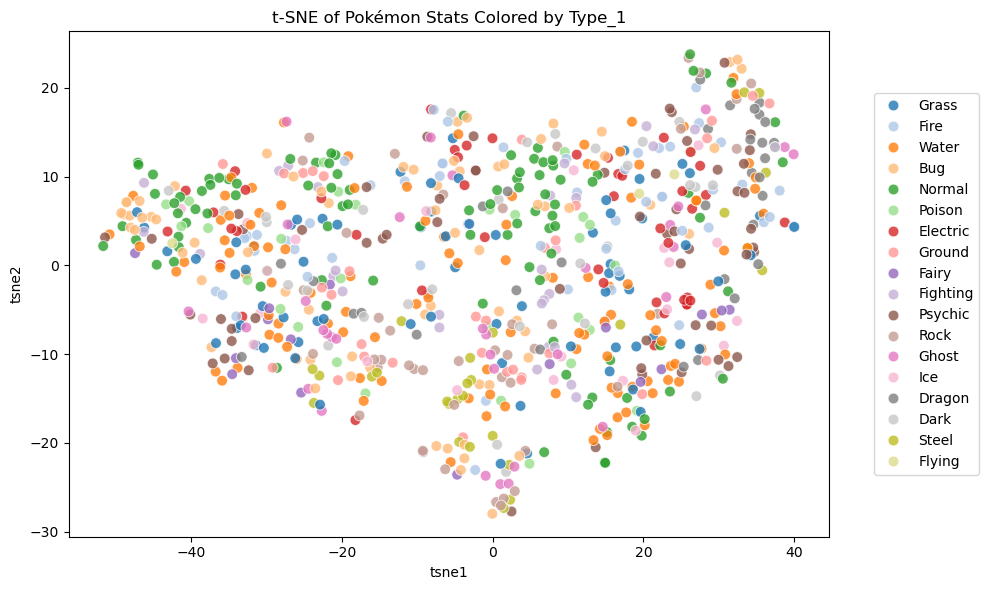

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="tsne1", y="tsne2", hue="Type_1", palette="tab20", s=60, alpha=0.8)
plt.title("t-SNE of Pokémon Stats Colored by Type_1")
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.show()


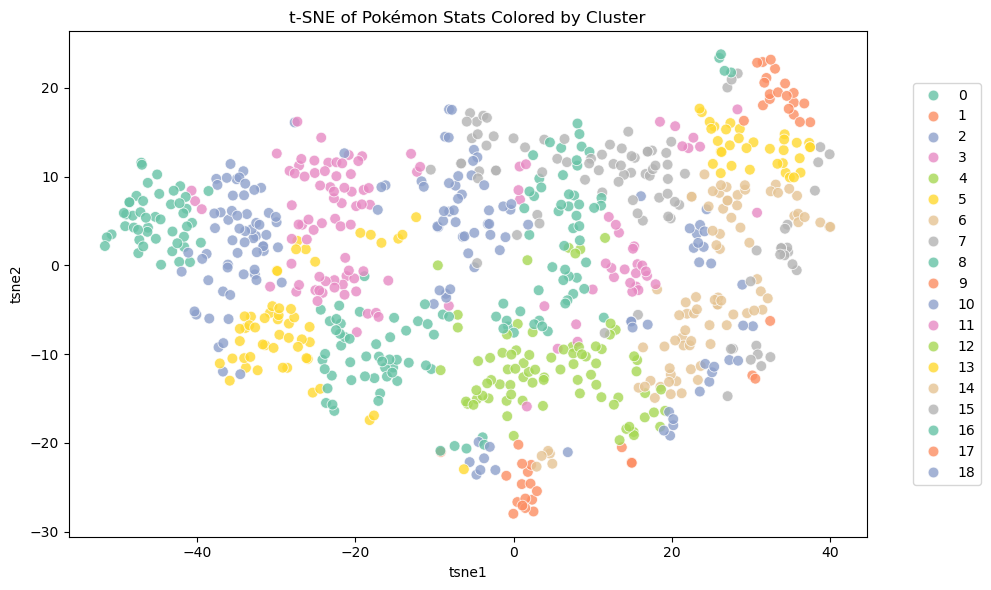

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="tsne1", y="tsne2", hue="cluster", palette="Set2", s=60, alpha=0.8)
plt.title("t-SNE of Pokémon Stats Colored by Cluster")
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.show()


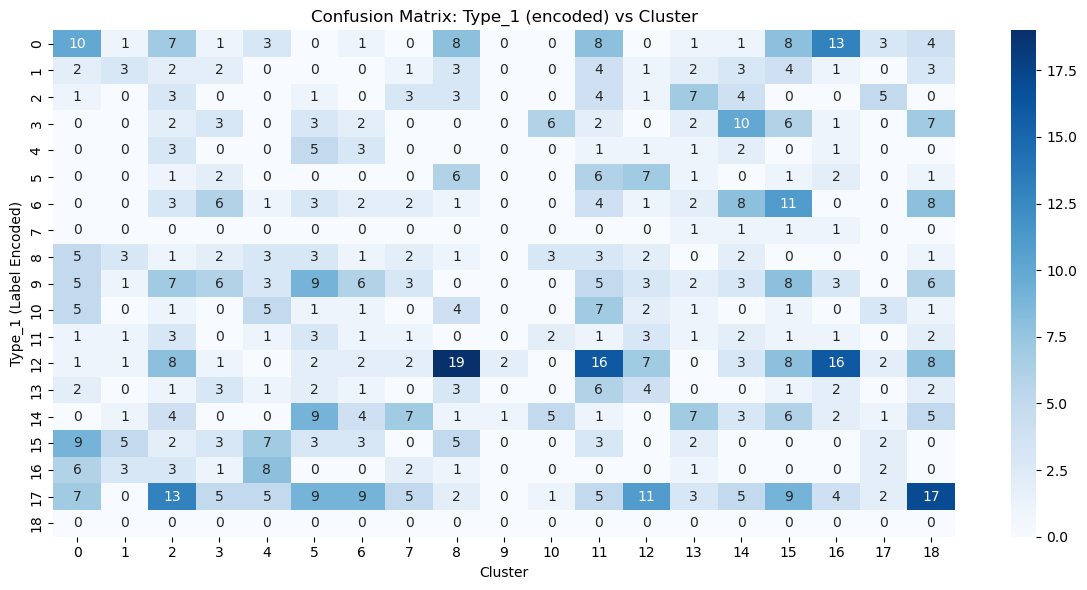

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Encode Type_1 as numeric labels
le = LabelEncoder()
df["type_label"] = le.fit_transform(df["Type_1"])

# Create confusion matrix
conf_mat = confusion_matrix(df["type_label"], df["cluster"])

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: Type_1 (encoded) vs Cluster")
plt.xlabel("Cluster")
plt.ylabel("Type_1 (Label Encoded)")
plt.tight_layout()
plt.show()
